# La Liga Data Analysis

## Package Requirements & Database

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from tabulate import tabulate
import openpyxl

ModuleNotFoundError: No module named 'openpyxl'

In [4]:
with sqlite3.connect("../laliga.sqlite") as con:
    df=pd.read_sql_query("SELECT * FROM Matches",con)
    dr=pd.read_sql_query("SELECT * FROM Predictions",con)

## Exercises

### Exercise 1
**Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.**

As can be seen in the pie chart below, it is indeed true that it is more likely for the home team to win, with a 52.8% chance. This is higher than the probability that there is a tie or that the away team wins.

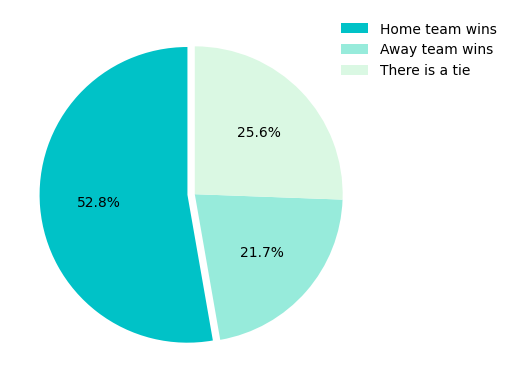

In [59]:
df = df.dropna(subset=['score'])

df["score_home_team"] = df["score"].str.split(":").str[0].astype(float)
df["score_away_team"] = df["score"].str.split(":").str[1].astype(float)

home_wins = (df['score_home_team'] > df['score_away_team']).sum()
away_wins = (df['score_home_team'] < df['score_away_team']).sum()
ties = (df['score_home_team'] == df['score_away_team']).sum()

sizes = [home_wins, away_wins, ties]
labels = ['Home team wins', 'Away team wins', 'There is a tie']
explode = (0.05, 0.0, 0.0)
colors = ['#00c2c7', '#97ebdb', '#daf8e3']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=['','',''], autopct='%1.1f%%', startangle=90, colors=colors)
ax.legend(wedges, labels, loc="upper right", bbox_to_anchor=(1.35, 1), fancybox=True, edgecolor='black', frameon=False)

plt.show()

### Exercise 2
**What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division. What have been the biggest wins? Of course, when we say _biggest_ we mean those with the highest goal difference. Show the top ten of them in a table.**

The ten highest scorers of the first division of La Liga can be seen in the two bar plot charts, respectively. When it comes to the 

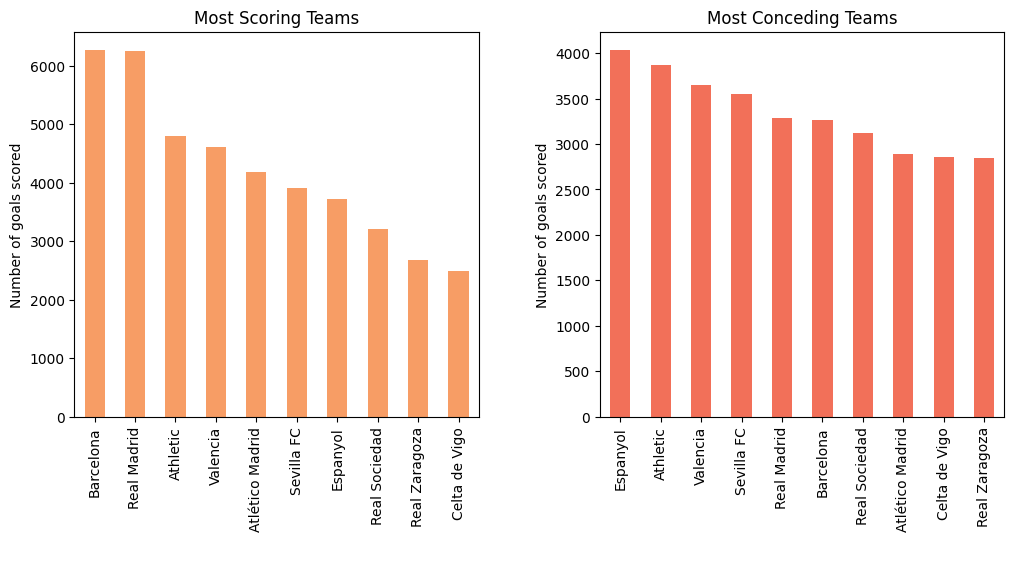

 score_difference           game_name           
        11                 Athletic vs Barcelona
        10               Sevilla FC vs Barcelona
        10                    Athletic vs Lérida
        10             Athletic vs Celta de Vigo
        10             Sevilla FC vs Real Oviedo
         9              Barcelona vs Real Oviedo
         9           Barcelona vs Rayo Vallecano
         9                      Racing vs Alavés
         9               Real Madrid vs Elche CF
         9        Atlético Madrid vs Hércules CF


In [67]:
df_first_division = df[df['division'] == 1].copy()  # make a copy of the dataframe to avoid a warning

goals_scored = df_first_division.groupby('home_team')['score_home_team'].sum() + df_first_division.groupby('away_team')['score_away_team'].sum()
top_scorers = goals_scored.sort_values(ascending=False).head(10)

goals_conceded = df_first_division.groupby('home_team')['score_away_team'].sum() + df_first_division.groupby('away_team')['score_home_team'].sum()
top_conceders = goals_conceded.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 5)) # increase the figure size for wider subplots

plt.subplot(1, 2, 1)
top_scorers.plot(x='nombre', y='valor', kind='bar', color='#f79d65')
plt.xlabel(' ')
plt.ylabel('Number of goals scored')
plt.title('Most Scoring Teams')

plt.subplot(1, 2, 2)
top_conceders.plot(x='nombre', y='valor', kind='bar', color='#f27059')
plt.xlabel(' ')
plt.ylabel('Number of goals scored')
plt.title('Most Conceding Teams')
plt.subplots_adjust(wspace=0.3)  # add space between subplots
plt.show()

df_first_division['score_difference'] = np.abs(df_first_division["score_home_team"] - df_first_division["score_away_team"])
df_first_division['game_name'] = df_first_division["home_team"] + ' vs ' + df_first_division["away_team"]
differences = df_first_division.iloc[:, -2:].sort_values(by='score_difference', ascending=False).head(10)

table = differences.to_string(index=False, header=True, justify='center', max_rows=10, max_cols=2, float_format="%.0f")
print(table)

### Exercise 3

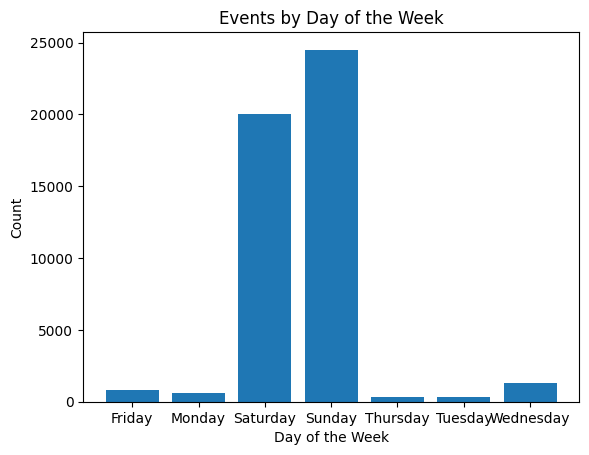

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df['Day_of_Week'] = df['date'].dt.day_name()

day_of_week_counts = df['Day_of_Week'].value_counts().sort_index()

plt.bar(day_of_week_counts.index, day_of_week_counts)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Events by Day of the Week')
plt.show()

### Exercise 4

#### Build a cross results table for season 2020-2021 (1st division). 

The code below, when executed, displays a cross table in which if the home team wins the background is color green, if the away team wins the background color is red and if there is a tie the background color is orange. 

In [130]:
#here we are creating a data frame with the results from the first division in season 2020-2021
df_season20_21=df_first_division[df_first_division['season']=='2020-2021'] 
#creation of the table
table=df_season20_21.pivot(index='home_team', columns='away_team',values='score')
table=table.fillna('-')

#function for coloring the table according to who wins de match
def coloring(value):
    if value=='-':
        return '' #the values of the table with '-' don't get coloured!!
    else:
        parts=value.split(":") #we are extracting the ':' in order to be able to compare scores!!!
        home_score=int(parts[0])
        away_score=int(parts[1])  
        if home_score>away_score:
            return 'background-color: rgba(144, 238, 144,0.55)'
        if home_score<away_score:
            return 'background-color: rgba(255, 37, 44,0.7)'
        if home_score==away_score:
            return 'background-color:rgb(255,179,71); color:black'
    
colored_table=table.style.map(coloring) 
display(colored_table)

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


#### Could you model the intensity of this background color with the goal difference from the match?

The code below does the same as the one in the cell above, but now we asign a difference intensity of the code according to the value of the difference between the score of the home team and the away team: as more different are the scores, the brighter the color gets.

In [133]:
df_season20_21=df_first_division[df_first_division['season']=='2020-2021']
table=df_season20_21.pivot(index='home_team', columns='away_team',values='score')
table=table.fillna('-')
#here we are calculating the maximum diference between scores that there is when the home team wins and when the away team wins
max_dif_homewins=(df_season20_21['score_home_team']-df_season20_21['score_away_team']).max()
max_dif_awaywins=(-df_season20_21['score_home_team']+df_season20_21['score_away_team']).max()

#function for coloring, now with gradients :)
def coloring_gradients(value):
    if value=='-':
        return '' 
    else:
        parts=value.split(":")
        home_score=float(parts[0])
        away_score=float(parts[1])
        if home_score>away_score:
            alpha=(home_score-away_score)/max_dif_homewins #this is the transparency that the cell acquires, as more difference, the less transparency there is
            if alpha>=0.8:
                return f'background-color:rgba(144, 238, 144, {alpha});color:black' #so the letters can be read!!!
            else:
                return f'background-color:rgba(144, 238, 144, {alpha});color:white'  
        if home_score<away_score:
            alpha=(-home_score+away_score)/max_dif_awaywins
            return f'background-color:rgba(255, 37, 44, {alpha})'
        if home_score==away_score:
            return 'background-color:rgb(255,179,71); color:black'
    
colored_table=table.style.map(coloring_gradients)

display(colored_table)

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


#### Write a function that, given the season ant the division, plots the cross section results table

Since we have two types of table created, we have two functions according to the type of colors you want (if you want the gradient or not).

Table without the gradient:

In [136]:
def table_for_any_season(x,y):
    df_unknown_div= df[df['division']==x]
    df_any_season=df_unknown_div[df_unknown_div['season']==y]
    table_any_seas=df_any_season.pivot_table(index='home_team', columns='away_team',values='score',aggfunc=list,fill_value='-',margins=False)
    table_any_seas=table.fillna('-')
    colored_table=table_any_seas.style.map(coloring) 
    return colored_table
#If you want to try the function with more values make sure to put first the number of the division (1 or 2) and the season with format 'year-year'
display(table_for_any_season(1,'2013-2012')) 

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


Table with the gradient:

In [138]:
def table_for_any_season_with_gradient(x,y):
    df_unknown_div= df[df['division']==x]
    df_any_season=df_unknown_div[df_unknown_div['season']==y]
    table_any_seas=df_any_season.pivot_table(index='home_team', columns='away_team',values='score',aggfunc=list,fill_value='-',margins=False)
    table_any_seas=table.fillna('-')
    colored_table_gradient=table_any_seas.style.map(coloring_gradients) 
    return colored_table_gradient
#same recquirements as before, first write the function (1 or 2) and then the season as 'year-year'
display(table_for_any_season_with_gradient(2,'2001-2000'))


away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


### Exercise 5

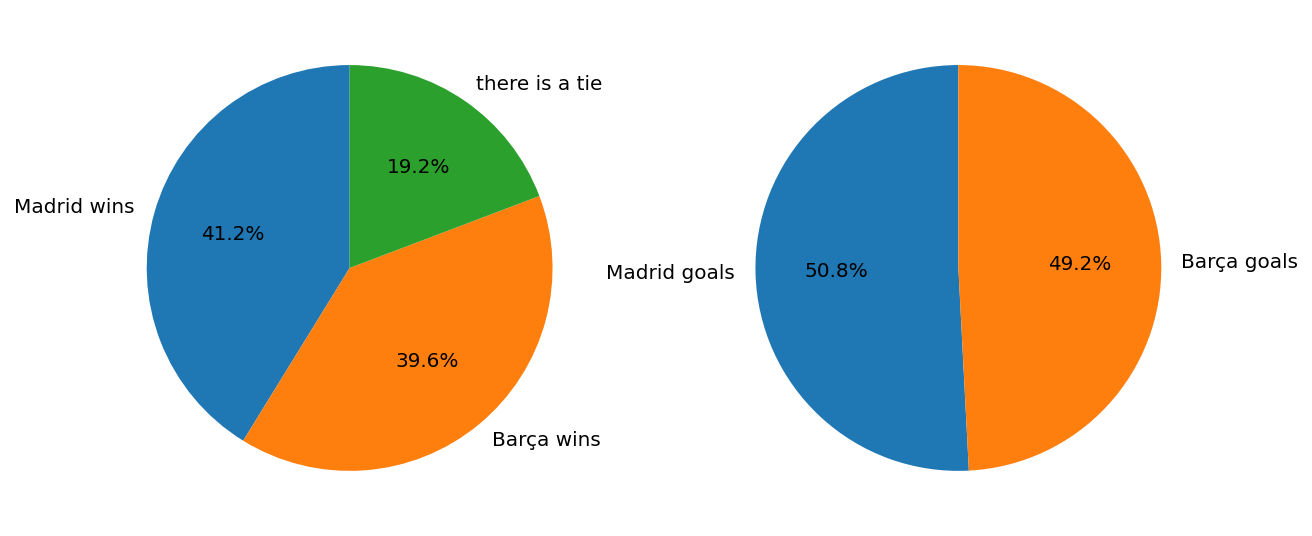

In [6]:
df_home_madrid = df[df['home_team'] == 'Real Madrid'] [df[df['home_team'] == 'Real Madrid'] ['away_team'] == 'Barcelona']
goals_madrid = df_home_madrid['score_home_team'].sum()
df_home_barca = df[df['home_team'] == 'Barcelona'] [df[df['home_team'] == 'Barcelona'] ['away_team'] == 'Real Madrid']
goals_barca = df_home_barca['score_home_team'].sum()

df_bar_vs_mad = pd.concat([df_home_madrid, df_home_barca])

madrid_wins = (df_home_madrid['score_home_team'] > df_home_madrid['score_away_team']).sum() + (df_home_barca['score_home_team'] < df_home_barca['score_away_team']).sum()
barca_wins = (df_home_barca['score_home_team'] > df_home_barca['score_away_team']).sum() + (df_home_madrid['score_home_team'] < df_home_madrid['score_away_team']).sum()
ties = (df_bar_vs_mad['score_home_team'] == df_bar_vs_mad['score_away_team']).sum()

sizes = [madrid_wins, barca_wins, ties]
labels = ['Madrid wins', 'Barça wins', 'there is a tie']

fig = plt.figure(figsize=(10,10),dpi=144)

ax1 = fig.add_subplot(121)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

sizes = [goals_madrid, goals_barca]
labels = ['Madrid goals', 'Barça goals']

ax2 = fig.add_subplot(122)
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()

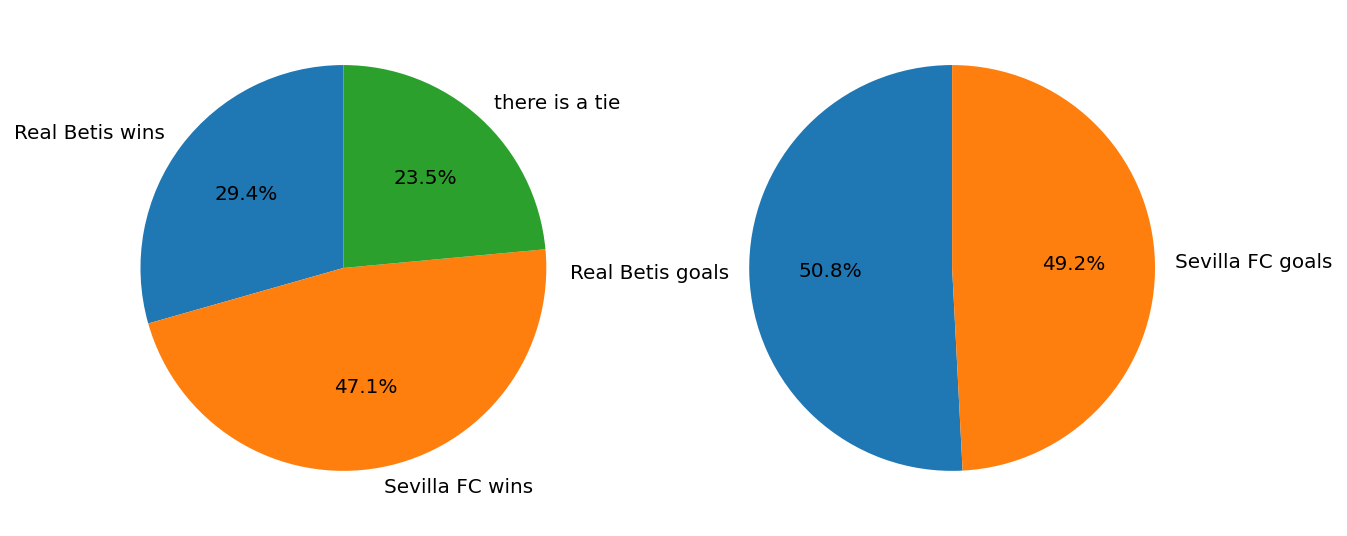

In [7]:
#function exercise 5
def plot_direct_confontations_stats(team1,team2):
    df_home_team1 = df[df['home_team'] == team1] [df[df['home_team'] == team1] ['away_team'] == team2]
    goals_team1 = df_home_team1['score_home_team'].sum()
    df_home_team2 = df[df['home_team'] == team2] [df[df['home_team'] == team2] ['away_team'] == team1]
    goals_team2 = df_home_team2['score_home_team'].sum()

    df_team1_vs_team2 = pd.concat([df_home_team1, df_home_team2])

    team1_wins = (df_home_team1['score_home_team'] > df_home_team1['score_away_team']).sum() + (df_home_team2['score_home_team'] < df_home_team2['score_away_team']).sum()
    team2_wins = (df_home_team2['score_home_team'] > df_home_team2['score_away_team']).sum() + (df_home_team1['score_home_team'] < df_home_team1['score_away_team']).sum()
    ties = (df_team1_vs_team2['score_home_team'] == df_team1_vs_team2['score_away_team']).sum()

    sizes = [team1_wins, team2_wins, ties]
    labels = [team1 + ' wins', team2 + ' wins', 'there is a tie']

    fig = plt.figure(figsize=(10,10),dpi=144)

    ax1 = fig.add_subplot(121)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

    sizes = [goals_madrid, goals_barca]
    labels = [team1 + ' goals', team2 + ' goals']

    ax2 = fig.add_subplot(122)
    ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.show()

plot_direct_confontations_stats('Real Betis','Sevilla FC')

### Exercise 6

### Exercise 7

In [8]:
df['Winner'] = np.where(df['score_home_team'] > df['score_away_team'],1,np.where(df['score_home_team'] < df['score_away_team'],0,-1))

def func_home_wins(data):
    return (data[data == 1]).count()

def func_away_wins(data):
    return (data[data == 0]).count()

def func_tie(data):
    return (data[data == -1]).count()

df_class_home = df.groupby(['division','season','home_team']).agg(
    GF = pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    GA = pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    W = pd.NamedAgg(column='Winner', aggfunc=func_home_wins),
    L = pd.NamedAgg(column='Winner', aggfunc=func_away_wins),
    T = pd.NamedAgg(column='Winner', aggfunc=func_tie)
    ).reset_index()
df_class_away = df.groupby(['division','season','away_team']).agg(
    GF = pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    GA = pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    W = pd.NamedAgg(column='Winner', aggfunc=func_away_wins),
    L = pd.NamedAgg(column='Winner', aggfunc=func_home_wins),
    T = pd.NamedAgg(column='Winner', aggfunc=func_tie)
    ).reset_index()

df_class_away.rename(columns={'away_team': 'team'}, inplace=True)
df_class_home.rename(columns={'home_team':'team'},inplace=True)

df_classifiaction = df_class_away.merge(df_class_home,how='outer')
# df_classifiaction[['GF','GA']] = df_class_home[['GF','GA']] + df_class_away[['GF','GA']]




df_classifiaction['GD'] = df_classifiaction['GF'] - df_classifiaction['GA']
df_classifiaction['Pts'] = (df_classifiaction['W']) * 3 + df_classifiaction['T']

df_classifiaction


df_classifiaction['year_of_start']=df_classifiaction['season'].str.split("-").str[0].astype(int)
 


df_classifiaction['Rank'] = df_classifiaction.groupby(['year_of_start'])['Pts'].rank(method='min', ascending=False)



df_classifiaction_ordered = df_classifiaction.sort_values(by=['year_of_start'], ascending=False)

df_classifiaction_ordered=df_classifiaction.sort_values(by=['year_of_start','division'],ascending=[False,True])

df_classifiaction_ordered=df_classifiaction.sort_values(by=['year_of_start','division','Rank'],ascending=[False,True,True])

df_classifiaction_ordered=df_classifiaction.sort_values(by=['year_of_start','division','Rank','GD'],ascending=[False,True,True,False])

df_classifiaction_ordered=df_classifiaction.sort_values(by=['year_of_start','division','Rank','GD','GF'],ascending=[False,True,True,False,False])

df_classifiaction_ordered=df_classifiaction_ordered.reset_index(drop=True)

df_final_classification_ordered=df_classifiaction_ordered.drop(columns=['year_of_start'])

df_final_classification_ordered
df_final_classification_ordered.to_excel('SeasonStandings.xlsx')

### Exercise 8

### Exercise 9

### Exercise 10